# 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from IPython.display import display, clear_output
np.random.seed(99)

# 2. Data Generation

## Dynamic number of sample can be genrated

In [2]:
def data_gen(size=1000):
    from sklearn.datasets import make_moons
    x, label = make_moons(n_samples=1000, noise=0.2, random_state=100)
    label = label.reshape(1000, 1)
    return x, label


sample = 1000
data, label = data_gen(sample)
print('Data Shape  = ', data.shape)
print('Label Shape = ', label.shape)

Data Shape  =  (1000, 2)
Label Shape =  (1000, 1)


# 3. Plot Data

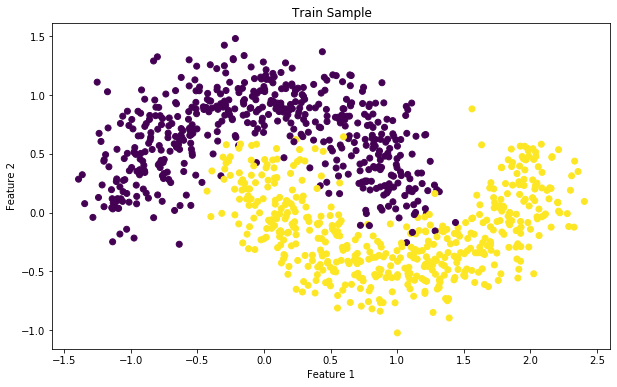

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], c=label[:, 0])
plt.title('Train Sample')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 4. Data Split

In [4]:
x_train, x_test, y_train, y_test = tts(data, label, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(900, 2) (900, 1)
(100, 2) (100, 1)


# 5. Neural Network Model

##  Logistic Neural Network for binary classifier

In [5]:
class nn():
    def __init__(self, x, y):

        self.row, self.col = x.shape[0], x.shape[1]
        self.x = x
        self.y = y

        self.bias = []
        self.theta = []

        self.layer_num = None

        self.layers_z = []
        self.layer_fun_name = []
        self.layers_a = []

        self.dz = []
        self.da = []
        self.dw = []
        self.db = []

    def theta_init(self, layer, fun_name):
        self.layer_num = len(layer)
        self.layer_fun_name = fun_name
        self.theta.append(np.random.randn(self.col, layer[0])*0.1)
        self.bias.append(np.random.randn(1, layer[0])*0.1)
        for i in range(1, self.layer_num):
            self.theta.append(np.random.randn(layer[i-1], layer[i])*0.1)
            self.bias.append(np.random.randn(1, layer[i])*0.1)

    def single_forward(self, i):
        z = np.matmul(self.layers_a[-1], self.theta[i])+self.bias[i]
        self.layers_z.append(z)
        if self.layer_fun_name[i] == 'relu':
            self.layers_a.append(self.relu(z))
        else:
            self.layers_a.append(self.sigmoid(z))

    def forward_prop(self, dataset=np.array([[]])):
        dataset = self.x if dataset.shape[1] == 0 else dataset

        self.layers_z = []
        self.layers_a = []

        self.layers_z.append(dataset)
        self.layers_a.append(dataset)

        for i in range(self.layer_num):
            self.single_forward(i)

    def single_back(self, i):

        m = self.layers_a[i-1].shape[0]
        if self.layer_fun_name[i-1] == 'relu':
            self.dz.append(self.da[-1]*self.relu_prime(self.layers_z[i]))
        else:
            self.dz.append(self.da[-1]*self.sigmoid_prime(self.layers_z[i]))
        self.dw.append(np.matmul(self.layers_a[i-1].T, self.dz[-1]) / m)
        self.db.append(np.sum(self.dz[-1], axis=0, keepdims=True) / m)
        self.da.append(np.matmul(self.dz[-1], self.theta[i-1].T))

    def back_prop(self, epoch=1000, alpha=0.001):
        self.cost_val = []

        fig = plt.figure(figsize=(14, 4))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.title.set_text('Train Sample')
        ax2.title.set_text('Model Cost')
        ax1.set_xlabel('Feature 1')
        ax1.set_ylabel('Feature 2')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Error')
        self.forward_prop()
        for k in range(epoch+1):
            self.dz = []
            self.da = []
            self.dw = []
            self.db = []

            self.da.append(- (np.divide(self.y,
                                        self.layers_a[-1]) - np.divide(1 - self.y, 1 - self.layers_a[-1])))
            for i in range(self.layer_num, 0, -1):
                self.single_back(i)
                self.theta[i-1] -= alpha*self.dw[-1]
                self.bias[i-1] -= alpha*self.db[-1]
                
            self.forward_prop()
            self.cost()
            if k % 100 == 0:
                ax1.cla()
                ax1.scatter(self.x[:, 0], self.x[:, 1],
                            c=self.prediction()[:, 0])
                ax2.cla()
                ax2.scatter(range(len(self.cost_val)), self.cost_val)
                ax1.title.set_text('Train Sample')
                ax2.title.set_text('Model Cost')
                ax1.set_xlabel('Feature 1')
                ax1.set_ylabel('Feature 2')
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Error')
                display(fig)
                print('Iteration      = {}\n{}'.format(
                    k, a.accuracy()), end='\r')
                clear_output(wait=True)
        print('Iteration      = {}\n{}'.format(k, a.accuracy()), end='\r')

    def cost(self):
        error = (1/self.row)*sum(-self.y *
                                 (np.log(self.layers_a[-1]))-(1-self.y)*(np.log(1-self.layers_a[-1])))
        self.cost_val.append(error)

    def prediction(self, *args):
        if len(args) != 0:
            self.forward_prop(args[0])
        else:
            self.forward_prop()
        pred = np.where(self.layers_a[-1] > 0.5, 1, 0)
        return pred

    def accuracy(self, *args):
        if len(args) != 0:
            return "Test Accuracy  = {:.2f}%".format((self.prediction(args[0]) == args[1]).mean()*100)
        else:
            return "Train Accuracy = {:.2f}%".format((self.prediction() == self.y).mean()*100)

    def relu(self, data):
        return np.where(data > 0, data, 0)

    def sigmoid(self, data):
        return 1/(1+np.exp(-data))

    def relu_prime(self, data):
        return np.where(data > 0, 1, 0)

    def sigmoid_prime(self, data):
        data = self.sigmoid(data)
        return data*(1-data)

# 6. Model initializer

## a. Number of layer & node in each layer can be dynamically alllocated
## b. Assign activation function for each layer

Iteration      = 5000


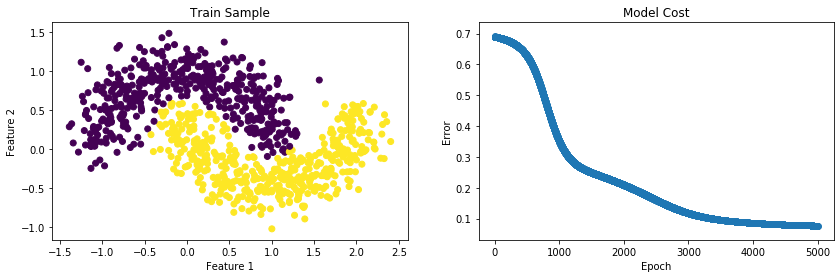

In [6]:
a = nn(x_train, y_train)

layer_list = [128,64,64,32,1]
activation_function = ['relu','relu','relu','relu','sigmoid']

a.theta_init(layer_list,activation_function)

epoch = 5000
alpha = .01

a.back_prop(epoch, alpha)

# 7. Model Performance

In [7]:
print(a.accuracy())
print(a.accuracy(x_test, y_test))

Train Accuracy = 97.00%
Test Accuracy  = 98.00%


# 8. Test Value Plot for Prediction

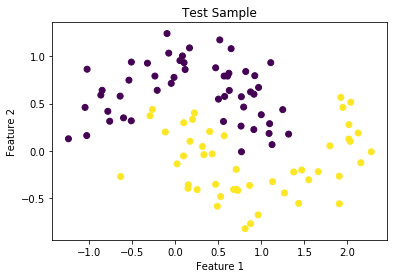

In [8]:
plt.figure()
plt.scatter(x_test[:, 0], x_test[:, 1], c=a.prediction(x_test)[:, 0])
plt.title('Test Sample')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()